In [ ]:
import torch #Redes neuronales
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torchvision

In [3]:
torch.cuda.is_available()

False

In [ ]:
#torch.cuda.current_device()

In [ ]:
#torch.cuda.get_device_name(0)

In [6]:
evice = torch.device("cpu")

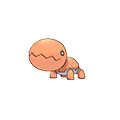

In [8]:
img = Image.open("C://Users//sebas//Downloads//archive (10)//images//trapinch.png") #Open image
img.thumbnail(size=(120,120)) #Make thumnbial
img

In [10]:
model = resnet50(weights="IMAGENET1K_V1") #Instanciamos el objeto
#model.to(device)

In [7]:
preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])
])